In [ ]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

In [ ]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [139]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import torch
import torch.nn as nn
# import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '../data/brain-segmentation'


In [3]:
train_dir = os.path.join(DATA_DIR, 'train')

valid_dir = os.path.join(DATA_DIR, 'val')

test_dir = os.path.join(DATA_DIR, 'test')

In [4]:
from dataset import BrainSegmentationDataset as Dataset
from transform import transforms
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        image = (image.numpy() * 255).astype(np.uint8)
        image = Image.fromarray(image) # if image.shape[0] == 3 else Image.fromarray(image, mode='1')
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [6]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

NameError: name 'BaseDataset' is not defined

In [34]:
# Lets look at data we have

def datasets():
    train = Dataset(
        images_dir='../data/brain-segmentation/train',
        image_size=256,
        transform=transforms(scale=0.05, angle=15, flip_prob=0.5),
    )
    valid = Dataset(
        images_dir='../data/brain-segmentation/val',
        image_size=256,
        random_sampling=False,
    )
    test = Dataset(
        images_dir='../data/brain-segmentation/test',
        image_size=256,
        random_sampling=False,
    )
    return train, valid, test

train_data, val_data, test_data = datasets()



reading images...
preprocessing volumes...
cropping volumes...
padding volumes...
resizing volumes...
normalizing volumes...
done creating dataset from ../data/brain-segmentation/train
reading images...
preprocessing volumes...
cropping volumes...
padding volumes...
resizing volumes...
normalizing volumes...
done creating dataset from ../data/brain-segmentation/val
reading images...
preprocessing volumes...
cropping volumes...
padding volumes...
resizing volumes...
normalizing volumes...
done creating dataset from ../data/brain-segmentation/test


In [46]:
# print(len(train_data) + len(val_data) + len(test_data))
print(len(test_data))

623


-0.726047 3.0039082 (256, 256, 3) float32


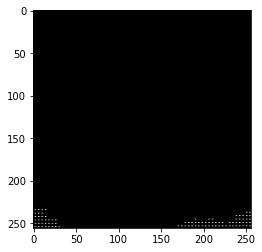

In [92]:
image, mask = train_data[30] # get some sample
np_mask = (np.array(mask) * 256).squeeze()
np_image = np.array(image).transpose(1, 2, 0)
print(np.min(np_image), np.max(np_image), np_image.shape, np_image.dtype)
i_image = Image.fromarray(np_image, mode='RGB')
m_image = Image.fromarray(np_mask, mode='L')
plt.imshow(i_image)
plt.imshow(m_image, cmap='gray')

In [167]:

class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

class DistanceMapLoss(nn.Module):
    def __init__(self, smooth: float = 1.0):
        super(DistanceMapLoss, self).__init__()
        self.smooth = smooth
        self.bce = nn.BCELoss(reduction='none')
    
    def forward(self, x, y, distance_map):
        assert x.size() == y.size()\
            and y.size() == distance_map.size(),\
            f'x shape {x.shape}, y shape {y.shape}, and map shape {map.shape} incompatible'

        loss = self.bce(x, y)
        loss *= distance_map + self.smooth
        return torch.sum(loss) / loss.shape[0]


class EdgeLoss(nn.Module):

    def __init__(self):
        super(EdgeLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true, weight_map=None):
        assert y_pred.size()[0] == y_true.size()[0]\
            and y_pred.size()[2:] == y_true.size()[2:],\
            f'Pred shape {y_pred.shape} incompatible with target shape {y_true.shape}'

        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)

        if weight_map == None:
            weight_map = torch.ones(y_true.shape).view(-1)
        else:
            weight_map = weight_map[:, 0].contiguous().view(-1)

        intersection = (y_pred * y_true * weight_map).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc


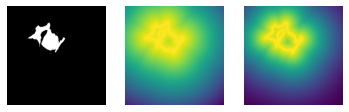

In [181]:
from scipy.ndimage.morphology import distance_transform_bf, distance_transform_edt
import skimage

raw_mask = Image.open('/Users/austinbrotman/Desktop/cs231n/stroke-segmentation/data/brain-segmentation/train/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif')

numpy_mask = np.array(raw_mask)

def compute_distance_map(input: np.ndarray, exp: float = 1) -> np.ndarray:
    internal = distance_transform_edt(input > 0)
    internal *= input > 0
    external = distance_transform_edt(input == 0)
    external *= input == 0
    d_map = internal + external
    d_map = -d_map + np.max(d_map)
    raw_max = d_map.max()
    raw_min = d_map.min()
    d_map = d_map**exp
    d_map = np.interp(d_map, (d_map.min(), d_map.max()), (raw_min, raw_max))
    return d_map

mask_distance = compute_distance_map(numpy_mask, exp=1)
mask_distance_sq = compute_distance_map(numpy_mask, exp=2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(numpy_mask, cmap='gray')
ax1.set_xlabel('Raw Mask')
ax1.axis('off')
ax2.imshow(mask_distance, cmap='viridis')
ax2.set_xlabel('Distance Map')
ax2.axis('off')
ax3.imshow(mask_distance_sq, cmap='viridis')
ax3.set_xlabel('Squared Distance Map')
ax3.axis('off')
fig.savefig('distance_maps.png', format='png')

In [179]:
y = np.array([[1, 1, 1, 1, 1],
              [0, 1, 1, 1, 1],
              [0, 0, 1, 1, 1],
              [0, 0, 0, 1, 1],
              [0, 0, 0, 0, 1]]).astype(np.uint8)
correct_x = y.copy()
x = np.array([[1, 1, 1, 1, 1],
              [0, 1, 1, 0, 1],
              [0, 0, 1, 1, 1],
              [0, 1, 0, 1, 1],
              [0, 0, 0, 0, 1]]).astype(np.uint8)
x = torch.tensor(x, dtype=torch.float, requires_grad=True)
y_map = torch.tensor(compute_distance_map(y), dtype=torch.float)
y_tensor = torch.tensor(y)
correct_x_tensor = torch.tensor(correct_x)
loss = nn.BCELoss(reduction='none')
map_loss = DistanceMapLoss()

correct_loss = loss(torch.tensor(correct_x, dtype=torch.float), torch.tensor(y, dtype=torch.float))
correct_two_off_loss = loss(x, torch.tensor(y, dtype=torch.float))
correct_two_off_loss.sum().backward()
# print(x.grad)
# print(correct_loss * (y_map+ 1))
# print(two_off_loss * (y_map + 1))
loss = map_loss(x.unsqueeze(0), torch.tensor(y, dtype=torch.float).unsqueeze(0), y_map.unsqueeze(0))
loss.backward()
print(x.grad)



tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -3.3695e+12,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  4.1913e+12,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])


## Model

In [13]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [14]:
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['mask']
ACTIVATION = None # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2471: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [16]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [17]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [19]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 101/101 [00:03<00:00, 32.53it/s, dice_loss - 0.3525, iou_score - 0.5599]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:03<00:00, 32.32it/s, dice_loss - 0.3014, iou_score - 0.6105]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:03<00:00, 32.59it/s, dice_loss - 0.2838, iou_score - 0.6298]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:03<00:00, 32.67it/s, dice_loss - 0.2725, iou_score - 0.638]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:03<00:00, 32.53it/s, dice_loss - 0.2358, iou_score - 0.6802]
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [00:03<00:00, 32.37it/s, dice_loss - 0.2155, iou_score - 0.7026]
Model saved!

Epoch: 6
valid: 100%|██████████| 101/101 [00:03<00:00, 32.35it/s, dice_loss - 0.2451, iou_score - 0.6708]

Epoch: 7
valid: 100%|██████████| 101/101 [00:03<00:00, 32.74it/s, dice_loss - 0.2657, iou_score - 0.6435]

Epoch: 8
valid: 100%|██████████| 101/101 [00:03<00:00, 32.16it/s, 

## Test best saved model

In [20]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [21]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [22]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:08<00:00, 27.19it/s, dice_loss - 0.1979, iou_score - 0.7498]


## Visualize predictions

In [23]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

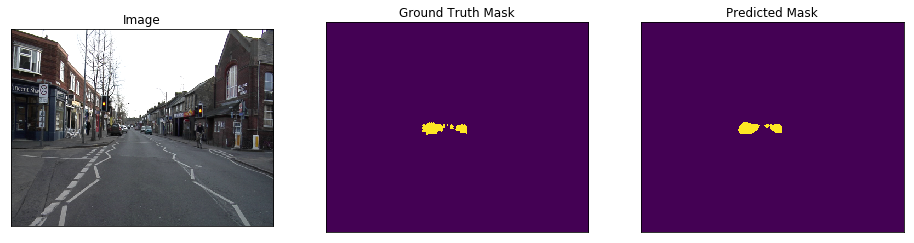

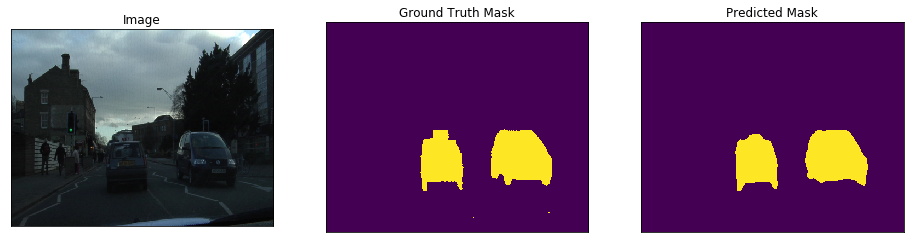

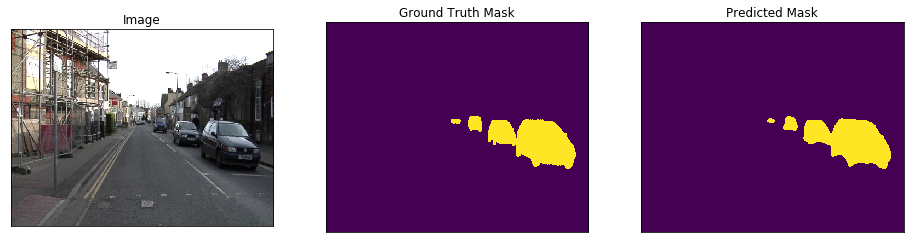

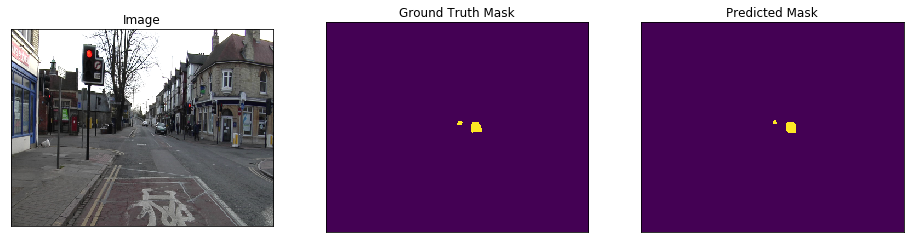

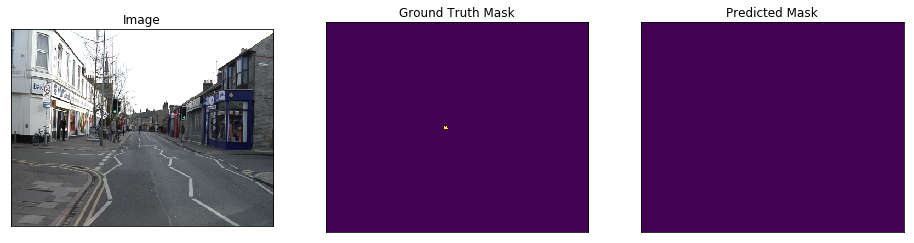

In [24]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )